# Graficacion Meteorologica Mediante Interpolaciones 🌡

<img src=Imagenes/App2.jpg width=300px>
<h3>Intregrantes:</h3>
<h4>Juan Vargas <br>
Freddy Jaimes <br>
Angel de Leon</h4>
<hr>

<h2>Tomamos los datos consumiendo una api del clima</h2>
<h5>https://developer.weatherunlocked.com/documentation/localweather/forecast</h5>
<h3>Elegimos la locacion de Turquia estambul</h3>
<img src=Imagenes/MemeTurco.jpg width=300px>
<hr>

## Consumo De Api para la Generacion de datos (1 Semana)

In [4]:
#Importamos las librerias necesarias
using HTTP
using JSON

#Pido los datos desde la api
url = "http://api.weatherunlocked.com/api/forecast/41.01384,-28.94966?app_id=f8341b8f&app_key=380d876792d6ac1b32c5258c07c010a4"
res = HTTP.get(url)
json = JSON.parse(String(res.body))

Temperatura_max = []
Temperatura_min = []
temperatura = []
x = json["Days"]

for i in x
    push!(Temperatura_max, i["temp_max_c"])
    push!(Temperatura_min, i["temp_min_c"])
end

for i in 1:1:length(Temperatura_max)
    temp_max = Temperatura_max[i]
    temp_min = Temperatura_min[i]
    prom = temp_max + temp_min
    push!(temperatura, round(prom/2 , digits=2))
end
print(temperatura)
typeof(temperatura)


Any[22.0, 23.0, 23.0, 24.1, 22.1, 21.6, 18.9]

Vector{Any} (alias for Array{Any, 1})

## Datos Meteorologicos anuales de Estambul

In [ ]:
api = "790e4819ffc841c5b1810355241106"
loc = "Istanbul"
doc = loc * "_weather_data.json"

data = []

for m in 1:12
    s_date = "2023-$(lpad(m, 2, '0'))-01"
    e_date = m != 12 ? "2023-$(lpad(m, 2, '0'))-31" : "2023-12-31"

    url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?q=$(loc)&tp=24&date=$(s_date)&enddate=$(e_date)&format=json&key=$(api)"

    res = HTTP.get(url)

    if res.status == 200
        d = JSON.parse(String(res.body))
        push!(data, d)
        println("Datos del mes $m obtenidos correctamente")
    else
        println("Error al obtener datos del mes $m: $(res.status)")
    end
end

meses = [
    "Enero",
    "Febrero",
    "Marzo",
    "Abril",
    "Mayo",
    "Junio",
    "Julio",
    "Agosto",
    "Septiembre",
    "Octubre",
    "Noviembre",
    "Diciembre",
]

max_t = []
min_t = []
avg_t = []

for m_data in data
    m_max_t = []
    m_min_t = []
    m_avg_t = []

    for day in m_data["data"]["weather"]
        max_t = day["maxtempC"]
        min_t = day["mintempC"]
        avg_t = day["avgtempC"]

        push!(m_max_t, max_t)
        push!(m_min_t, min_t)
        push!(m_avg_t, avg_t)
    end

    push!(max_t, m_max_t)
    push!(min_t, m_min_t)
    push!(avg_t, m_avg_t)
end



<hr>

## Interpolacion de Taylor

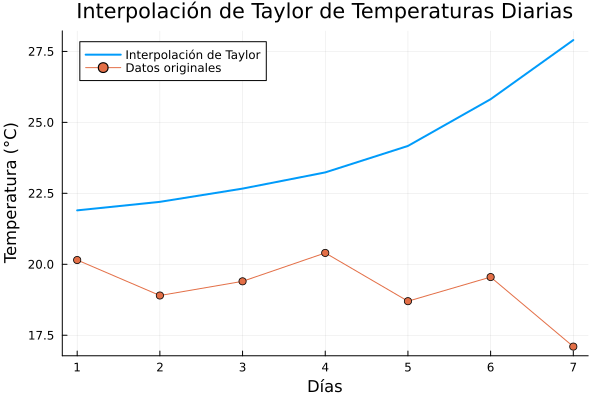

In [9]:
using SymPy
using Plots

using Plots

function taylor_series(temperatura, time, x0)
    c_temperatura = [temperatura]
    temp = [1,2,3,4,5,6,7]
    for i in temp
        if i <= length(c_temperatura[1]) - 1
            push!(c_temperatura, [diff(c_temperatura[1])[i]])
        else
            push!(c_temperatura, [0.0]) 
        end
    end

    f_pol = 0
    for i in temp
        fact = factorial(i)
        if i <= length(c_temperatura)
            pol = c_temperatura[i][1] / fact
            for j in 1:(i - 1)
                pol *= (x0 - time[j])
            end
            f_pol += pol
        end
    end

    result = f_pol
    return result, x0
end


time = [1,2,3,4,5,6,7]
result, x0 = taylor_series(temperatura, time, 3)

x_vals = [1,2,3,4,5,6,7]
f_pol_vals = [taylor_series(temperatura, time, x_val)[1] for x_val in x_vals]

plot(x_vals, f_pol_vals, label="Interpolación de Taylor", linewidth=2)
plot!(time, temperaturas, label="Datos originales", marker=:circle)
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación de Taylor de Temperaturas Diarias")

## Interpolacion de Lagrange

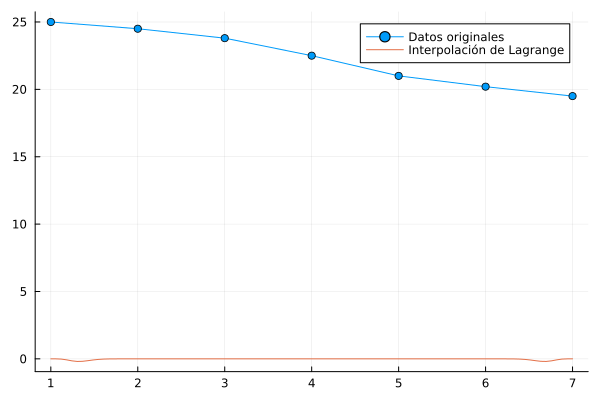

In [15]:
using SymPy
días = [1, 2, 3, 4, 5, 6, 7]


function lagrange_interpolation(x, xi, yi)
    """
    Calcula el polinomio interpolante de Lagrange.
    x: Valor a interpolar
    xi: Array de valores x conocidos
    yi: Array de valores y conocidos
    """
    n = length(xi)
    L = ones(size(x))
    for i in 1:n
        for j in 1:n
            if i!= j
                L.= L.* (x.- xi[j])./ (xi[i] - xi[j])
            end
        end
    end
    return sum(yi.* L)
end

puntos_evaluación = range(1, 7, length=100)
temperaturas_interpoladas = [lagrange_interpolation(x, días, temperatura) for x in puntos_evaluación]


plot(días, temperaturas, label="Datos originales", marker=:circle)
plot!(puntos_evaluación, temperaturas_interpoladas, label="Interpolación de Lagrange")

## Interpolacion de Hermit

In [21]:
using PyCall
using Plots

np = pyimport("numpy")

function derivada(x, y)
    n = length(x) #cantidad de elementos de x
    dy = np.zeros(n) #crea una array llena de ceros de tamano n

    dy[1] = (y[2] - y[1]) / (x[2] - x[1]) #se deriva el primer punto

    dy[end] = (y[end] - y[end-1]) / (x[end] - x[end-1]) # se deriva el ultimo punto

    for i in 2:n-1
        dy[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1]) # se derivan los puntos que estan desde la segunda posicion y la penultima
    end
    
    return dy #se retorna la derivada
end





#Generar puntos correspondientes
x = np.Arrays(1:7) #crea un array de uno a siete
y = temperatura #se llama a la array temperatura como y


x = convert(Array{Float64}, x)#Convierte la array x a una array float si no lo era antes


dy = derivada(x, y)




KeyError: KeyError: key :Arrays not found